In [1]:
import wandb
# import util
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import shutil
import wandb
from PIL import Image
import os
import glob
from pathlib import Path

from tqdm.notebook import tqdm
from skimage.io import imread,imsave 

In [2]:
%reload_ext autoreload
%autoreload 2

from bioblue.nb.load import load_from_dir, load_from_dir2
# from bioblue.nb import *

In [13]:
# run_dir = Path("/globalscratch/users/n/s/nsayez/outputs/2022-06-05/14-29-30")
run_dir = Path("/globalscratch/users/n/s/nsayez/outputs/2022-06-05/18-24-05")


## Run the prediction on the manually annotated images

In [14]:
config, model, dm, trainer = load_from_dir2(
                                    run_path= run_dir,
                                    load_trainer=True,
                                    override = [
                                        '~callbacks.wandb',
                                        f'callbacks.Save_prediction.output_dir={str(run_dir/"predictions")}'
                                    ]
                                )
test_dataloader = dm.test_dataloader()

# results = trainer.test(model, datamodule=dm)
# # results = trainer.test(model, dataloaders=test_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


bioblue.loss.CombineLosses
['sunspot']


## Run DICE computation

In [15]:
def generalized_dice_coefficient( y_true, y_pred,  smooth= 1e-5):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (
                np.sum(y_true_f) + np.sum(y_pred_f) + smooth)
    return score

In [29]:
cfg_dataset = config["dataset"]

dtypes_paths = {}
for t in  cfg_dataset["train_dataset"]['dtypes'][1:]:
    
    p = Path(cfg_dataset["data_dir"]) / cfg_dataset["dataset_name"]
    p = p / cfg_dataset["test_dataset"]["partition"] /t
#     cfg_dataset["train_dataset"]["partition"]/ t
    dtypes_paths[t] = str(p)
print(dtypes_paths)

{'T400_single': '/globalscratch/users/n/s/nsayez/deepsun_bioblue/All/test_GT/T400_single'}


In [20]:
dataset_root = "/globalscratch/users/n/s/nsayez/deepsun_bioblue/All/test_GT"

image_folder = os.path.join(dataset_root, 'image')
image_lst = sorted(glob.glob(os.path.join(image_folder, '*.FTS')))

seg_types = ['GroundTruth_single']
gt_folders = {t : os.path.join(dataset_root, t) for t in seg_types}
gt_lst = sorted(glob.glob(os.path.join(gt_folders['GroundTruth_single'], '*.png')))

preds = sorted(glob.glob(os.path.join(str(run_dir / 'predictions'), '*.png')))
gens = {t: sorted(glob.glob(os.path.join(p, '*.png'))) for t, p in dtypes_paths.items()}

pred_dices = []
gen_dices = []
for idx in range(len(image_lst)):
    test_img_name = image_lst[idx]
    test_label_name = gt_lst[idx]
    gen_label_name = gens[cfg_dataset["train_dataset"]['dtypes'][1]][idx]
    pred_label_name = preds[idx]

#     print(test_img_name)
#     print(test_label_name)
#     print(gen_label_name)
#     print(pred_label_name)
#     print()

    assert os.path.basename(test_img_name).split('.')[0] == \
            os.path.basename(test_label_name).split('.')[0] == \
            os.path.basename(pred_label_name).split('.')[0] == \
            os.path.basename(gen_label_name).split('.')[0]
    
    test_img = imread(test_img_name)
    test_label = imread(test_label_name)
    pred_label = imread(pred_label_name)
    gen_label = imread(gen_label_name)
    
    pred_dice = generalized_dice_coefficient(test_label, pred_label)
    pred_dices.append(pred_dice)
    
    gen_dice = generalized_dice_coefficient(test_label, gen_label)
    gen_dices.append(gen_dice)
    
    print(f"\t idx={idx} gen_dice: {gen_dice}, pred_dice: {pred_dice}")

mean_gen_dice = np.array(gen_dices).mean()
mean_pred_dice = np.array(pred_dices).mean()

print("\n mean_gen_dice: ",mean_gen_dice, " mean_pred_dice: ", mean_pred_dice)

	 idx=0 gen_dice: 0.9124266880984376, pred_dice: 0.9200039749975136
	 idx=1 gen_dice: 0.8303370791282666, pred_dice: 0.8184760228935687
	 idx=2 gen_dice: 0.9217234008208162, pred_dice: 0.922664432406649
	 idx=3 gen_dice: 0.816317626927754, pred_dice: 0.7832422591456234
	 idx=4 gen_dice: 0.8228295223807125, pred_dice: 0.7439320390939198
	 idx=5 gen_dice: 0.852309099560336, pred_dice: 0.8441045884457213
	 idx=6 gen_dice: 0.8862206978667219, pred_dice: 0.8712928307765827
	 idx=7 gen_dice: 0.851081647102468, pred_dice: 0.8181685837557598
	 idx=8 gen_dice: 0.6228239918215862, pred_dice: 0.601178789760731
	 idx=9 gen_dice: 0.8753888381743926, pred_dice: 0.8474894417198597
	 idx=10 gen_dice: 0.8684013010580427, pred_dice: 0.8414958744733192
	 idx=11 gen_dice: 0.828236538443433, pred_dice: 0.83577176313481
	 idx=12 gen_dice: 0.8448022402206494, pred_dice: 0.8577538530655897
	 idx=13 gen_dice: 0.5315855977075402, pred_dice: 0.768657511158674
	 idx=14 gen_dice: 0.8924720547111761, pred_dice: 0.8

## Connect to the finished run

In [41]:
wandb_dir = run_dir / "wandb"

entity = "nielssayez"
project = "Deepsun"
runid = None
for path in Path(wandb_dir).iterdir():
        if path.is_dir() and str(path.stem).startswith('run') :
            runid = str(path.stem).split(('-'))[-1]
print(runid)

dtsgj1sr


In [42]:
api = wandb.Api()
run = api.run(f"{entity}/{project}/{runid}")

## Log DICE accuracy to remote server

In [43]:
run.summary["test_DICE"] = mean_pred_dice
run.summary["gen_DICE"] = mean_gen_dice
run.summary.update()

## View Predictions

In [34]:
seg_types = ['GroundTruth_single']

dataset_root = "/globalscratch/users/n/s/nsayez/deepsun_bioblue/All/test_GT"

image_folder = os.path.join(dataset_root, 'image')
gt_folders = {t : os.path.join(dataset_root, t) for t in seg_types}

run_folders = { f"CNN-{cfg_dataset['train_dataset']['dtypes'][1]}": str(run_dir)}

pred_folders = {t: os.path.join(run_folders[t] , 'predictions') for t in run_folders.keys()}
pred_lsts = {t : sorted(glob.glob(os.path.join(pred_folders[t], '*.png'))) for t in run_folders.keys()}

gen_seg_types = [cfg_dataset['train_dataset']['dtypes'][1]]
generated_folders = {t : os.path.join(dataset_root, t) for t in gen_seg_types}
generated_lsts = {t : sorted(glob.glob(os.path.join(generated_folders[t], '*.png'))) for t in gen_seg_types}

image_lst = sorted(glob.glob(os.path.join(image_folder, '*.FTS')))
gt_lst = sorted(glob.glob(os.path.join(gt_folders['GroundTruth_single'], '*.png')))

print(len(image_lst))
print(len(pred_lsts[list(pred_lsts.keys())[0]]))
print(len(generated_lsts[list(generated_lsts.keys())[0]]))

pred_lst = pred_lsts[list(pred_lsts.keys())[0]]

36
36
36


In [35]:
%matplotlib ipympl

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import ipywidgets as widgets

max_rows = 2
max_cols = 2

max_idx = len(gt_lst)

cmap_gen = cm.winter
cmap_gen = cmap_gen(range(255))
cmap_gen = ListedColormap([(0, 0, 0, 0), *cmap_gen])

cmap_pred = cm.cool
cmap_pred = cmap_pred(range(255))
cmap_pred = ListedColormap([(0, 0, 0, 0), *cmap_pred])

cmap_gt = cm.Wistia
cmap_gt = cmap_gt(range(255))
cmap_gt = ListedColormap([(0, 0, 0, 0), *cmap_gt])


def refresh(slider): 
    xlims0 = axes0[0].get_xlim()
    ylims0 = axes0[0].get_ylim()
    
    axes0[0].clear()
    
    test_img = imread(image_lst[idx_slider.value])
    test_label = imread(gt_lst[idx_slider.value])
    
    if img_cb.value:
        axes0[0].imshow(test_img, cmap="gray", interpolation="None")
    if gt_cb.value:
        axes0[0].imshow(test_label, cmap=cmap_gt, interpolation="None", alpha=.5)
    
    for i, cb in enumerate(pred_cbs):
        if cb.value: 
            tmp = imread(pred_lsts[list(pred_folders.keys())[i]][idx_slider.value])
            axes0[0].imshow(tmp, cmap=cmap_pred, interpolation="None", alpha=.5)  
#             axes0[0].imshow(tmp, interpolation="None")  

    for i, cb in enumerate(gen_cbs):
        if cb.value: 
            tmp = imread(generated_lsts[list(generated_folders.keys())[i]][idx_slider.value])
            axes0[0].imshow(tmp, cmap=cmap_gen, interpolation="None", alpha=.5)  
        
    if xlims0 != (0.0, 1.0):
        axes0[0].set_xlim(xlims0)
        axes0[0].set_ylim(ylims0)
    return

max_rows = 1
max_cols = 1

plt.ioff()
fig_widget0, axes0 = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(7,7))

try:
    len(axes0)
except TypeError:
    axes0 = [axes0]

plt.ion()
img_cb = widgets.Checkbox(value=True, description='Show img')
gt_cb = widgets.Checkbox(value=False, description='Show gt')
pred_cbs = [widgets.Checkbox(value=False, description=f'PRED {t}') for t in pred_folders.keys()]
gen_cbs  = [widgets.Checkbox(value=False, description=f'GEN {t}') for t in generated_folders.keys()]

idx_slider = widgets.IntSlider(value=0, min=0, max=max_idx-1, step=1, description="Image Index")


# Input image to predict
test_img = imread(image_lst[0])
#Target corresponding to input
test_label = imread(gt_lst[0])
#prediction
pred_label = imread(pred_lst[0])

axes0[0].imshow(test_img, cmap="gray", interpolation="None")

img_cb.observe(refresh, names='value')
gt_cb.observe(refresh, names='value')
for cb in pred_cbs:
    cb.observe(refresh, names='value')
for cb in gen_cbs:
    cb.observe(refresh, names='value')
idx_slider.observe(refresh, names='value')

widgets.VBox([idx_slider,widgets.HBox([ img_cb, gt_cb]+gen_cbs+pred_cbs), fig_widget0.canvas])

## Poubelle

In [5]:
# !pip install -U ipykernel

In [8]:
# config, model, dm, trainer = load_from_dir2(
#                                     run_path= run_dir,
#                                     load_trainer=True,
#                                     override = [
#                                         f'callbacks.Save_prediction.output_dir={str(run_dir/"predictions")}'

#                                     ]
#                                 )
# test_dataloader = dm.test_dataloader()

# next(iter(test_dataloader))

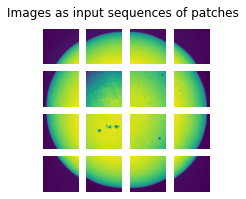

In [7]:
def img_to_patch_HW(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    H, W = x.shape
    y = x.copy()
    y = y.reshape(H // patch_size, patch_size, W // patch_size, patch_size)
#     print(y.shape)
    y = np.moveaxis(y, source=(1,2,3), destination=(2,1,3))
#     print(y.shape)
    y = y.reshape((y.shape[0]*y.shape[1], y.shape[2], y.shape[3]))
#     print(y.shape)
    return y

img_fn = "/globalscratch/users/n/s/nsayez/deepsun_bioblue/All/test_GT/image/UPH20130113150018.FTS"
my_image = io.imread(img_fn).astype(np.int32)
# print(my_image.shape)

img_patches = img_to_patch_HW(my_image, patch_size=512, flatten_channels=False)

fig, ax = plt.subplots(4, 4, figsize=(3, 3))
fig.suptitle("Images as input sequences of patches")
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(img_patches[(4*i)+j])
        ax[i,j].axis("off")
plt.show()
plt.close()


In [6]:
import torch
import skimage.io as io

def img_to_patch_BCHW(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    print(x.shape)
    return x

# img_fn = "/globalscratch/users/n/s/nsayez/deepsun_bioblue/All/test_GT/image/UPH20130113150018.FTS"
# my_image = torch.from_numpy(io.imread(img_fn).astype(np.int32))[None,None,:,:]
# print(my_image.shape)

# img_patches = img_to_patch_BCHW(my_image, patch_size=512, flatten_channels=False)
# img_patches.flatten(0,1).shape

In [8]:
# from hydra import initialize_config_module, initialize_config_dir, initialize, compose



# config_path = run_dir / ".hydra/config.yaml"

# override = [
# #                 "server=mb-mil101",
#                 "logger=csv_logger"
#             ]
# # override = ["logger=csv_logger"]
# # cfg = OmegaConf.load(config_path)

# print(str(config_path.parents[0].resolve()))


# with initialize_config_dir(config_dir=str(config_path.parents[0])):
#     cfg = compose(
#         config_name="config", overrides=override, return_hydra_config=True
#     )
    
# #     print(cfg)


/auto/globalscratch/users/n/s/nsayez/outputs/2022-06-05/14-29-30/.hydra


In [7]:
# from hydra import initialize_config_module as init_hydra, compose

# config_path = run_dir / ".hydra/config.yaml"

# override = [
# #                 "server=mb-mil101",
# #                 "logger=csv_logger"
#             ]
# # override = ["logger=csv_logger"]

# cfg = OmegaConf.load(config_path)



# # print(cfg)

# with init_hydra(config_module="bioblue.conf"):
#     cfg2 = compose(
#         config_name="config", overrides=override, return_hydra_config=True,strict=False
#     )
# #     print(type(cfg2))

# # print(cfg2)
# cfg = OmegaConf.merge(cfg, cfg2)

